# Моделирование развития городов с помощью клеточных автоматов
Выполнил студент: группы БПМИ226, 2 курса, Леонтенков Егор Евгеньевич

In [1]:
# Импортирование нужных библиотек
import numpy as np
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate
import random

## Обработка датасета

<p style="text-indent: 4em;"> Так как на предыдущем шаге мы получили изображения, то некоторые пиксели, характеризовавшие классы, стали размытыми из-за свойств преобразования карт в изображения, что в дальнейшем могло повлиять на работу алгоритма. Во избежание проблем, было решено, что нужно обновить каждое изображение. То есть для каждого изображения отнести пиксели к <<идеальным>> цветам (характеризовавшим классы) с помощью формулы цветового отличия.

\begin{equation}
    \label{colors}
        D = \sqrt{(R_{base} - R)^2 + (G_{base} - G)^2 + (B_{base} - B)^2},
\end{equation}
где:
* R,G,B - каналы проверяемого цвета;
* \_base - это каналы <<идеального>> цвета, относительно которого проверяем;
* D - удаленность проверяемого цвета от идеального.


<p style="text-indent: 4em;"> Чтобы отнести полученный цвет к некоторому классу: производится сортировка D по возрастанию для каждого цвета и выбирается наименьший по цветовому отличию класс. Таблицу <<идеальных>> цветов можно наблюдать ниже.


In [2]:
data_2015 = np.array(Image.open("data/2015_data.png").convert('RGB'))
data_2020 = np.array(Image.open("data/2020_data.png").convert('RGB'))
data_2024 = np.array(Image.open("data/2024_data.png").convert('RGB'))
None

/Users/egorleontenkov/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (149671875 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


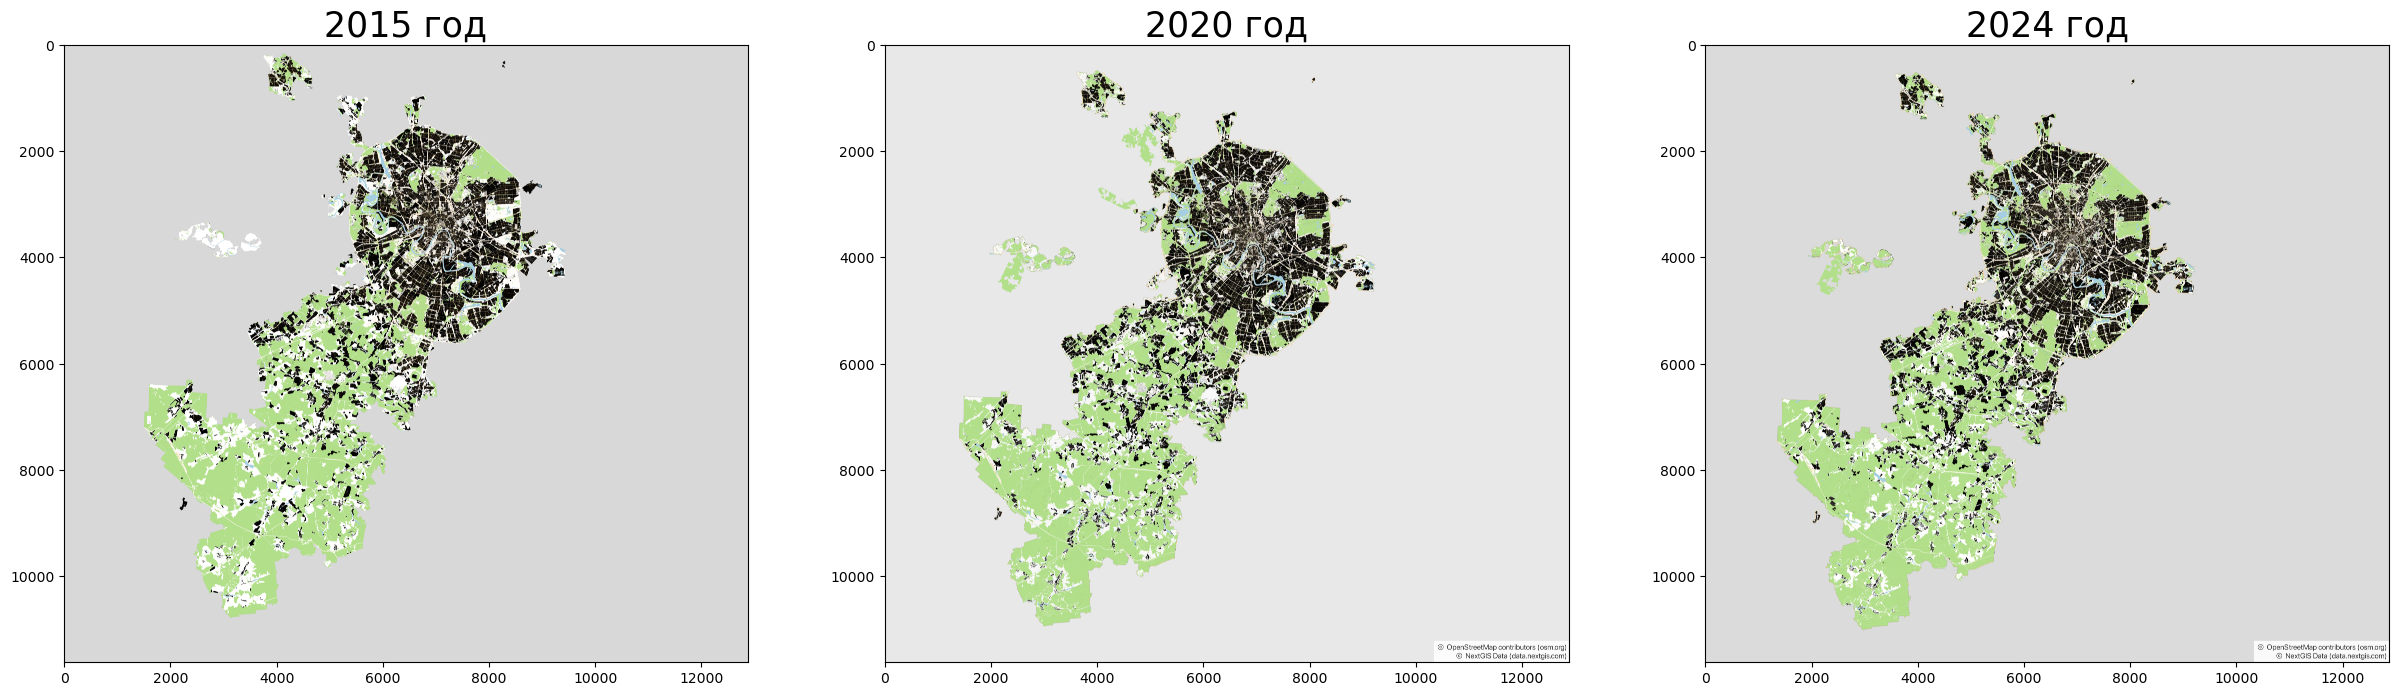

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

axes[0].imshow(data_2015)
axes[0].set_title('2015 год', fontsize=25)
axes[1].imshow(data_2020)
axes[1].set_title('2020 год', fontsize=25)
axes[2].imshow(data_2024)
axes[2].set_title('2024 год', fontsize=25)
None

In [4]:
fig.savefig('До_обработки_big.png',bbox_inches='tight')

<p style="text-indent: 4em;"> Также выберем идеальные цвета для новых изображений:

|Класс (номер) | Цвет (представление в RGB) |
| --- | --- |
| Empty (0) | Серый (222, 222, 222)|
| Water (1) | Синий (174, 208, 220)|
| Urban (2) | Черный (0, 0, 0)|
| Road (3) | Оранжевый (255, 184, 65) |
| Land (4)| Зеленый (168, 228, 160) |
| Vegetation (5) | Белый (255, 255, 255) |

In [5]:
# Функция для присваивания верного цвета
def NeedColor(color):
    '''
    Input:
    color - numpy array with RGB for color
    Output:
    np.array with of correct color
    '''
    compare_with_colors = np.ones(6)
    colors = {
        0: np.array([222, 222, 222]),
        1: np.array([174, 208, 220]),
        2: np.array([0,0,0]),
        3: np.array([255, 184, 65]),
        4: np.array([168,228,160]),
        5: np.array([255, 255, 255])
    }
    
    # empty
    compare_with_colors[0] = np.sqrt(np.sum((colors[0] - color) ** 2))
    # water
    compare_with_colors[1] = np.sqrt(np.sum((colors[1] - color) ** 2))
    # urban
    compare_with_colors[2] = np.sqrt(np.sum((colors[2] - color) ** 2))
    # road
    compare_with_colors[3] = np.sqrt(np.sum((colors[3] - color) ** 2))
    # land
    compare_with_colors[4] = np.sqrt(np.sum((colors[4] - color) ** 2))
    # Vegetation
    compare_with_colors[5] = np.sqrt(np.sum((colors[5] - color) ** 2))
    
    # sort by color
    sorted_by_color = np.argsort(compare_with_colors)
    
    # sorted_by_color[0] - the closest perfect color
    return colors[sorted_by_color[0]]

In [6]:
def CardProcessing(image):
    '''
    Input:
    image - numpy array with RGB, size: (11625, 12875, 3)
    Output:
    new_image - numpy array with RGB and new colors, size: (11625, 9000, 3)
    '''
    new_image = np.zeros((image.shape[0], 9000, 3))
    # walk along the original photo
    for i in range(image.shape[0]):
        for j in range(1000, 10000):
            new_image[i][j - 1000] = NeedColor(image[i][j])
    
    return new_image

In [7]:
data_2015 = CardProcessing(data_2015)
data_2020 = CardProcessing(data_2020)
data_2024 = CardProcessing(data_2024)

In [8]:
image_2015 = Image.fromarray(data_2015.astype('uint8')).convert("RGB")
image_2020 = Image.fromarray(data_2020.astype('uint8')).convert("RGB")
image_2024 = Image.fromarray(data_2024.astype('uint8')).convert("RGB")

<p style="text-indent: 4em;"> Получаем изображения, содержащие только 6 видов пикселей.

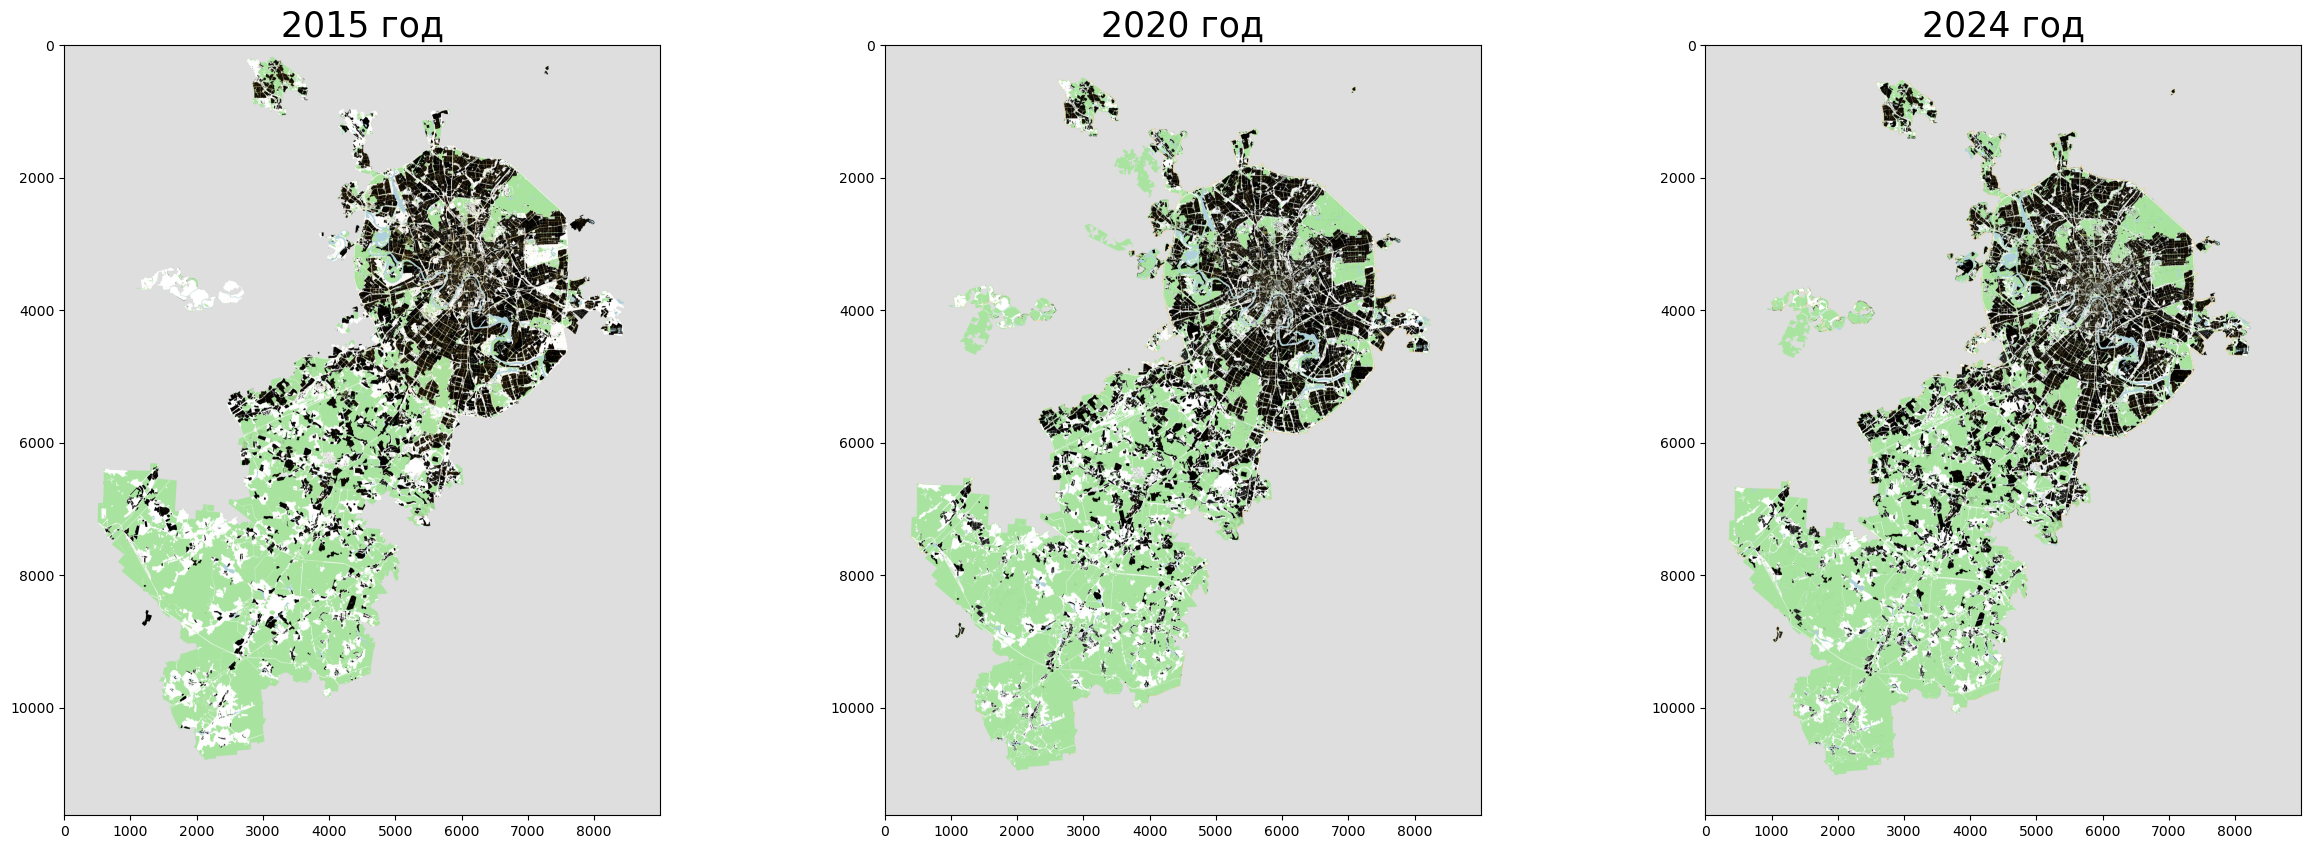

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

axes[0].imshow(image_2015)
axes[0].set_title('2015 год', fontsize=25)
axes[1].imshow(image_2020)
axes[1].set_title('2020 год', fontsize=25)
axes[2].imshow(image_2024)
axes[2].set_title('2024 год', fontsize=25)
None

<p style="text-indent: 4em;"> После предварительного просмотра полученных карт обнаружилось, что на изображениях карты расположены со смещениями. Например: верняя точка карты для 2015 года была расположена выше, чем верхняя точка для 2020 года. Это также может повлиять на результат работы алгоритма, из-за чего централизируем карты.

Напишем функцию, которая будет выводить в каких границах лежит карта.

In [10]:
def MapBorders(data):
    '''
    Input:
    data - numpy array with RGB and new colors, size: (11625, 9000, 3)
    Output:
    2 lists with points and difference
    first list contains points for axis=1
    second list contains points for axis=0
    '''
    lower_i = None
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.array_equal(data[i][j], np.array([222, 222, 222])):
                lower_i = i
                break
        if not lower_i is None:
            break
    
    upper_i = None
    for i in range(data.shape[0] - 1, -1, -1):
        for j in range(data.shape[1]):
            if not np.array_equal(data[i][j], np.array([222, 222, 222])):
                upper_i = i
                break
        if not upper_i is None:
            break
            
    left_j = None
    for j in range(data.shape[1]):
        for i in range(data.shape[0]):
            if not np.array_equal(data[i][j], np.array([222, 222, 222])):
                left_j = j
                break
        if not left_j is None:
            break
            
    right_j = None
    for j in range(data.shape[1] - 1, -1, -1):
        for i in range(data.shape[0]):
            if not np.array_equal(data[i][j], np.array([222, 222, 222])):
                right_j = j
                break
        if not right_j is None:
            break
            
    return [lower_i, upper_i, upper_i - lower_i], [left_j, right_j, right_j - left_j]

In [11]:
print(MapBorders(data_2015))
print(MapBorders(data_2020))
print(MapBorders(data_2024))

([176, 10794, 10618], [507, 8456, 7949])
([492, 10955, 10463], [392, 8230, 7838])
([525, 11023, 10498], [359, 8233, 7874])


<p style="text-indent: 4em;">Как и ожидалось наши изображения смещены по двум осям.

<p style="text-indent: 4em;">Также заметим, что  карты имеют разные размеры. Но так как их размеры различаются максимум на 150 клеток по одной оси, мы можем считать это погрешностью для работы алгоритма.
Теперь создадим новые карты, которые будут централизованы. Размеры карт станут: (10800, 8100, 3)

In [15]:
def CentralizationForMap(data, new_shape=(10800, 8100, 3)):
    '''
    Input:
    data - numpy array with RGB and new colors, size: (11625, 9000, 3)
    Output:
    Centralization for map based on points from MapBorders function
    '''
    steps_i, steps_j = MapBorders(data) 
    
    if steps_i[2] % 2 != 0:
        steps_i[2] += 1
        steps_i[0] -= 1
    if steps_j[2] % 2 != 0:
        steps_j[2] += 1
        steps_j[0] -= 1

    left = steps_j[0] - (new_shape[1] - steps_j[2]) // 2
    right = steps_j[1] + (new_shape[1] - steps_j[2]) // 2
    lower = steps_i[0] - (new_shape[0] - steps_i[2]) // 2
    upper = steps_i[1] + (new_shape[0] - steps_i[2]) // 2
    
    new_data = np.full(new_shape, 222)  
    new_data = data[lower:upper + 1, left:right+1]
    
    return new_data

In [16]:
data_2015 = CentralizationForMap(data_2015)
data_2020 = CentralizationForMap(data_2020)
data_2024 = CentralizationForMap(data_2024)

In [17]:
image_2015 = Image.fromarray(data_2015.astype('uint8')).convert("RGB")
image_2020 = Image.fromarray(data_2020.astype('uint8')).convert("RGB")
image_2024 = Image.fromarray(data_2024.astype('uint8')).convert("RGB")

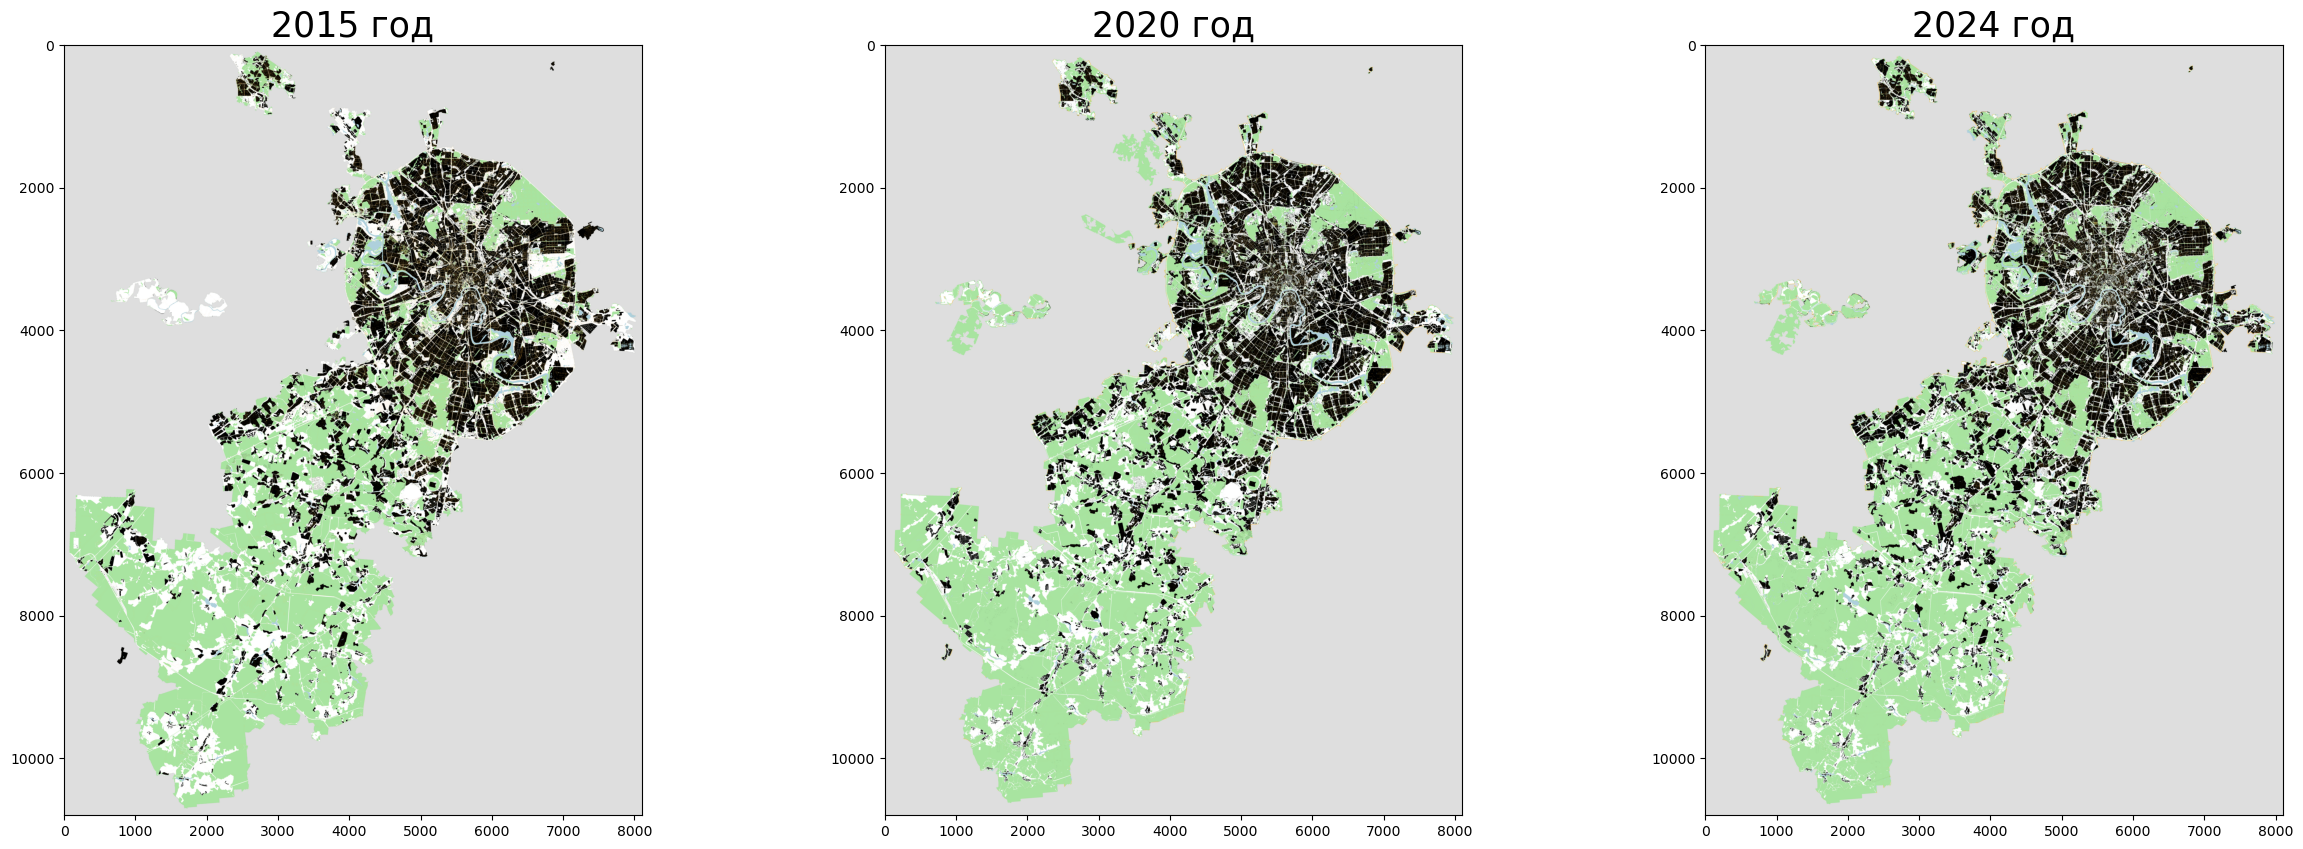

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

axes[0].imshow(image_2015)
axes[0].set_title('2015 год', fontsize=25)
axes[1].imshow(image_2020)
axes[1].set_title('2020 год', fontsize=25)
axes[2].imshow(image_2024)
axes[2].set_title('2024 год', fontsize=25)
None

In [29]:
fig.savefig('После_обработки_big.png',bbox_inches='tight')

Как мы и хотели, наши карты размещены по центру.

Обработка датасета на этом закончена. Переходим к самой модели.

## Построение моделей для алгоритма

<p style="text-indent: 4em;"> В данном исследовании будем использовать модель Markov Chain-Cellular Automata, чтобы спрогнозировать расширение города на 2029-2030 годы. Выбранна именно данная модель, потому что существует мало реализаций алгоритмов с клеточным автоматом, использующим цепь Макрова.

### Описание модели:
<p style="text-indent: 4em;"> Создание модели клеточного автомата Маркова (CAM) для прогнозирования изменений землепользования включает в себя оценку матрицы вероятности перехода и моделирование изменений землепользования с течением времени. Цепь Макрова — последовательность случайных событий с конечным или счётным числом исходов, где вероятность наступления каждого события зависит только от состояния, достигнутого в предыдущем событии. Характеризуется тем свойством, что при текущем настоящем состоянии системы, её будущее состояние не зависит от прошлого. Модель CAM может быть математически представлена следующим образом:
\begin{equation}
    \label{prob_for_land}
        L_{t+k} = P_{ij} \cdot L_t,~\text{для типов землеиспользования}~i,j = 1,2, ..., n
\end{equation}
<p style="text-indent: 4em;"> Где $L_{t}$ и $L_{t+k}$ - карты землепользования в год $t$ и $t+k$ соответственно, а $P_{ij}$ - это матрица вероятности перехода, выражающая вероятность того, что каждая ячейка изменится с типа землепользования $i$ в год $t$ на тип землепользования $j$ в год $t+k$. Таким образом, эту матрицу можно выразить следующим образом:
\begin{equation}
    \label{mat_prob}
        P_{ij} = 
        \begin{bmatrix}
       P_{11} & P_{12} & ... & P_{1n} \\
       P_{21} & P_{22} & ... & P_{2n} \\
       \vdots  & \vdots & \ddots & \vdots \\
       P_{n1} & P_{n2} & ... & P_{nn}
     \end{bmatrix} ,~\text{где}~ 0 \leq P_{ij} \leq 1,~\sum_{j=1}^n P_{ij} = 1
\end{equation}

### Реализация
Для того чтобы построить модель нам предварительно нужно релизовать несколько функций и классов.

* GetClass будет выдавать номер класса по цвету;
* GetColor будет выдавать цвет по номеру класса.

In [30]:
def GetClass(color):
    '''
    Input:
    color - RGB for pixel
    Output:
    class of pixel
    '''
    if np.array_equal(color, np.array([222, 222, 222])):
        return 0
    if np.array_equal(color, np.array([174, 208, 220])):
        return 1
    if np.array_equal(color, np.array([0, 0, 0])):
        return 2
    if np.array_equal(color, np.array([255, 184, 65])):
        return 3
    if np.array_equal(color, np.array([168, 228, 160])):
        return 4
    if np.array_equal(color, np.array([255, 255, 255])):
        return 5


def GetColor(class_of_using):
    '''
    Input:
    class_of_using - class of pixel
    Output:
    RGB for pixel
    '''
    colors = {
        0: np.array([222, 222, 222]),
        1: np.array([174, 208, 220]),
        2: np.array([0, 0, 0]),
        3: np.array([255, 184, 65]),
        4: np.array([168, 228, 160]),
        5: np.array([255, 255, 255])
    }
    return colors[class_of_using]

Создадим класс MarkovMap, который будет работать с данными из карты, он понадобится нам в дальнейшем. 

Класс содержит методы:
* PixelClass - выдает класс для клетки (RGB);
* PixelColors - выдает клетку - цвет в RGB;
* Lines - высота изображения;
* Columns - ширина изображения;
*  GetNeighbors для элемента из матрицы с изображением находит шестизначное число (сумма цифр 9), где каждый элемент отвечает за количество соседей (включая сам элемент) соответствующего класса. Например, для некоторой клетки получается строка '003222', которая показывает, что у некоторого элемента соседей класса 0 было 0, класса 1 - 0, класса 2 - 3, класса 3 - 2, класса 4 - 2, класса 5 - 2.

In [31]:
class MarkovMap:
    '''
    Сlass which processes the resulting map
    '''
    
    def __init__(self, data):
        '''
        Input:
        data - np.array(Image.open("data/___.png").convert('RGB')); data for input map
        '''
        self.data = data
        self.data_shape = data.shape
        
        self.neighbors = np.full(self.data.shape, -1)
        
        for i in range (data.shape[0]):
            for j in range (data.shape[1]):
                self.neighbors[i][j] = self.GetNeighbors(i, j)
    
    def PixelClass(self, i, j):
        return GetClass(self.data[i][j])
    
    def PixelColor(self, i, j):
        return self.data[i][j]
    
    def Lines(self):
        return self.data.shape[0]
    
    def Columns(self):
        return self.data.shape[1]
    
    def GetNeighbors(self, i, j):
        '''
        Input:
        i, j - indexes of element
        Output:
        if cell doesn't have empty neighbors and cell not empty => numbers of each class in the neighbors
                in number (for a convenient hash)
        else -1
        '''
        if i > 0 and  i < self.Lines() - 1 and j > 0 and j < self.Columns() - 1:
            count = 0
            classes_of_neighbors = list()
            classes_of_neighbors.append(self.PixelClass(i - 1, j - 1))
            classes_of_neighbors.append(self.PixelClass(i - 1, j))
            classes_of_neighbors.append(self.PixelClass(i - 1, j + 1))
            classes_of_neighbors.append(self.PixelClass(i, j - 1))
            classes_of_neighbors.append(self.PixelClass(i, j))
            classes_of_neighbors.append(self.PixelClass(i, j + 1))
            classes_of_neighbors.append(self.PixelClass(i + 1, j - 1))
            classes_of_neighbors.append(self.PixelClass(i + 1, j))
            classes_of_neighbors.append(self.PixelClass(i + 1, j + 1))
            classes_of_neighbors = np.array(classes_of_neighbors)
            
            count = np.count_nonzero(classes_of_neighbors == 5) + \
                    10 * np.count_nonzero(classes_of_neighbors == 4) + \
                    100 * np.count_nonzero(classes_of_neighbors == 3) + \
                    1000 * np.count_nonzero(classes_of_neighbors == 2) + \
                    10000 * np.count_nonzero(classes_of_neighbors == 1) + \
                    100000 * np.count_nonzero(classes_of_neighbors == 0)

            return count
        else:
            return -1

Функция CompareImages будет сравнивать данные с двух карт. Смотрит изменения количества клеток, принадлежащих классам.

In [32]:
def CompareMaps(first_map, second_map, first_name='old', second_name='new'):
    '''
    Input:
    first_map - map for first year
    second_map - map for second year
    first_name - first year in the comparison (default = 'old')
    second_name - second year in the comparison (default = 'new')
    Output:
    table with differences between years
    '''
    info_first = [0, 0, 0, 0, 0, 0]
    info_second = [0, 0, 0, 0, 0, 0]
    
    for i in range (first_map.shape[0]):
        for j in range (first_map.shape[1]):
            info_first[GetClass(first_map[i][j])] += 1
            info_second[GetClass(second_map[i][j])] += 1
            
    row0 = ['Image', 'Empty', 'Water', 'Urban', 'Road', 'Land', 'Vegetation']
    row1 = [first_name] + info_first
    row2 = ["Change in %", 0, 0, 0, 0, 0, 0]
    row3 = [second_name] + info_second

    for i in range (6):
        try:
            row2[i + 1] = (row3[i + 1] / row1[i+1] * 100 - 100) 
        except:
            row2[i + 1] = 0
    table = [row0, row1, row2, row3]
    
    print(tabulate(table, headers='firstrow', tablefmt='grid'))

### Предлагаемый метод «Basic»
<p style="text-indent: 4em;"> Реализуем функцию BasicCA_Fit (собственно наш клеточкный автомат). Описание представленно ниже.

<p style="text-indent: 4em;"> Во время обучения Basic рассчитывает «перекрестную таблицу» двух карт разных лет $(t, t+k)$, и строит матрицу вероятностей, разделяя каждый элемент строки на сумму элементов в строке, в итоге получает матрицу (нумерация с нуля), где в i строке j столбце описана вероятность перехода из класса i в класс j за период $k$ (пустой класс всегда переходит в пустой). Если даны несколько карт для годов $t$, $t+k$, $t+2k$,..., $t+nk$ , то метод рассчитывает матрицы вероятностей для карт из пар $(t,~t+k)$, $(t+k,~t+2k)$,..., $(t + (n-1)k,~t + nk)$, суммирует матрицы и делит на общее количество пар, из чего получает более точную матрицу вероятностей для моделирования на $k$ лет вперед.

In [33]:
def BasicCA_Fit(first_map, second_map):
    '''
    Input:
    first_map -map (not MarkovMap) for first year
    second_map - map (not MarkovMap) for second year
    Output:
    probabilities_matrix - np.array with probabilities 
    '''            
    change_matrix = np.zeros((6, 6)).astype(np.float32)

    for i in range (second_map.shape[0]):
        for j in range (second_map.shape[1]):
            change_matrix[GetClass(first_map[i,j])][GetClass(second_map[i,j])] += 1
            
    sum_in_rows = change_matrix.sum(axis=1)
    probabilities_matrix = np.full((6, 6), 0).astype(np.float32)
    

    for i in range (1, 6):
        probabilities_matrix[i] = change_matrix[i] / sum_in_rows[i] 
        
    # probability from empty to empty = 0
    probabilities_matrix[0][0] = 1
    
    return probabilities_matrix

Реализуем функцию CA_Predict, которая будет моделировать развитие города с помощью карты. 

Моделирование развития города происходит следующим образом:
* На вход поступает изображение в виде матрицы $data$ для года $t$ и матрица вероятностей для моделирования на $k$ лет вперед. Создаем пустую матрицу $predict$ с размером матрицы $data$;
* Выполняем циклы по $i$ и $j$, которые отвечают за строку и колонку в матрице соответсвенно;
* Для элемента $data[i][j]$ находим класс (в виде числа), которому он принадлежит;
* Проводиться эксперимент с мультиномиальным распределением с параметрами $N=1$, $n=6$, $p^n$ - строка матрицы вероятностей с номером полученным из пункта 3. В итоге из некоторой реализации в виде вектора мы получаем индекс $index$ (число от 0 до 5) для максимального элемента в векторе,  то есть номер класса, который встречался максимальное количество раз в нашем эксперименте.
* Присваиваем элементу $predict[i][j]$ цвет для класса $index$ из пункта 4.
* Продолжаем цикл по $i$ и $j$ пока не обработаем всю матрицу $data$;
* В итоге получаем матрицу  $predict$ - прогноз на год $t + k$.


In [34]:
def CA_Predict(data, input_map):
    '''
    Input:
    data - np.array with probabilities  (result from BasicCA_Fit)
    input_map - map for which we will predict LULC
    Output:
    predicted map
    '''
    predict_map = np.zeros((input_map.shape[0], input_map.shape[1], 3))
    
    for i in range (input_map.shape[0]):
        for j in range (input_map.shape[1]):
            predict_map[i][j] = GetColor(np.argmax(np.random.multinomial(1, data[GetClass(input_map[i, j])])))

    return predict_map

### Предлагаемый метод «Update»
<p style="text-indent: 4em;">Предсказание и обучение для метода Update происходит аналгично Basic. Главное отличие в расчете матрицы вероятностей. 

<p style="text-indent: 4em;">После того как мы получили матрицу вероятностей из обучения Basic, мы повышаем вероятность перехода класса в самого себя до $0,75$ (если она меньше этого числа). Также вероятность перехода непустого класса в пустой понижаем до нуля. Обуславливается этот прием логикой и различием в масштабах карт из датасета. Например: Москва-река располагается на одном месте на карте_1, но на карте_2 Москва-река расположена немного выше, из чего не следует смещение позиции реки. Таким образом, для каждой строки мы получаем число difference равное разности вероятности перехода непустого класса в пустой и вероятностью, на которую мы повысили переход класса в самого себя. В каждой строке $i$ распределим вероятность difference между классами (кроме класса 0 и $i$) пропорционально их доле. Далее проводим моделирование c новой матрицей вероятностей аналгично методу Basic.

In [35]:
def UpdateCA_Fit(first_map, second_map):
    '''
    Input:
    first_map - map for first year
    second_map - map for second year
    Output:
    probabilities_matrix - np.array with probabilities 
    '''            
    change_matrix = np.zeros((6, 6)).astype(np.float32)

    for i in range (second_map.shape[0]):
        for j in range (second_map.shape[1]):
            change_matrix[GetClass(first_map[i,j])][GetClass(second_map[i,j])] += 1
            
    sum_in_rows = change_matrix.sum(axis=1)
    probabilities_matrix = np.full((6, 6), 0).astype(np.float32)
    

    for i in range (1, 6):
        probabilities_matrix[i] = change_matrix[i] / sum_in_rows[i]
        # take into account class 0 and main class
        difference = probabilities_matrix[i][0]
        probabilities_matrix[i][0] = 0
        total_prob_with_out_main = 1 - probabilities_matrix[i][i] - difference
        if probabilities_matrix[i][i] < 0.75:
            difference -= (0.75 - probabilities_matrix[i][i])
            probabilities_matrix[i][i] = 0.75
        for j in range(1, 6):
            if i != j:
                probabilities_matrix[i][j] += (difference * probabilities_matrix[i][j] / total_prob_with_out_main)
        
    # probability from empty to empty = 0
    probabilities_matrix[0][0] = 1
    
    return probabilities_matrix

### Предлагаемый метод «Neighbors»
Описание обучения в методе Neighbors:
* На вход поступает словарь dict, data\_1 - матрица с изображением для карты с годом $t$, data\_2 - матрица с изображением для карты с годом $t+k$.  Ключом словаря dict является шестизначное число, а значением - массив из 6 элементов, где для индекса $m$ хранится количество переходов данной комбинации соседей в класс $m$;
* Выполняем циклы по $i$ и $j$, которые отвечают за строку и колонку в матрицах соответсвенно;
* Для элемента data\_1[i][j] получаем число num из функции GetNeighbors;
* * Если ключ num есть в словаре, то продолжаем;
* * Иначе создаем массив длины 6 , заполненный нулями, переходим к шагу 4;

* Для элемента data\_2[i][j] находим класс $c$ (в виде числа), которому он принадлежит;
* Инкриментируем dict[num][c];
* Продолжаем цикл по $i$ и $j$ пока не обработаем матрицы;
* Для каждого ключа преобразовываем массив с количеством в массив вероятностей перехода num в класс, поделив каждый элемент массива на сумму элементов в массиве.


Предсказание развития города для метода в зависимости от режима mode:
* На вход поступает изображение в виде матрицы $data$ для года $t$ и словарь dict на $k$ лет вперед, полученный при обучении. Создаем пустую матрицу $predict$ с размером матрицы $data$;
* Выполняем циклы по $i$ и $j$, которые отвечают за строку и колонку в матрице соответсвенно;
* Для элемента data[i][j] получаем число num из функции GetNeighbors;
* * Если ключ num есть в словаре, то продолжаем;
* * Иначе  predict[i][j] = data[i][j], переходим к шагу 5;
* Элементу predict[i][j] присваивается нужный цвет в зависимости от режима для предсказаний:
* * mode=0. Проводиться эксперимент с мультиномиальным распределением с параметрами $N=1$, $n=6$, $p^n$ = dict[num]. Присваиваем элементу цвет индекса, отвечавшему максимальному элементу в реализации;
* * mode=1. Присваиваем элементу цвет индекса, отвечавшему максимальному элементу в dict[num] (класс с максимальной вероятностью);
* Продолжаем цикл по $i$ и $j$ пока не обработаем всю матрицу $data$;
* В итоге получаем матрицу  $predict$ - прогноз на год $t + k$.

NeighborsCA_Fit будет создавать словарь, основываясь на котором будет производиться прогнозирование. На вход будет подаваться три карты для лучшего обучения.
NeighborsCA_Predict будет получать словарь, ключи которого комбинации соседей для клетки, а значения - вероятности для каждого соседа, и выдавать прогнозирование.

In [36]:
def NeighborsCA_Fit(first_map, second_map, third_map):
    '''
    Input:
    first_map - MarkovMap for first year
    second_map - MarkovMap for second year
    third_map - MarkovMap for second year
    Output:
    data - dictionary with probabilities for types neighbors
    '''
    data = dict()

    for i in range (first_map.Lines()):
        for j in range (first_map.Columns()):
            
            if first_map.GetNeighbors(i, j) != -1 and second_map.GetNeighbors(i, j) != -1:
                neighbors_1 = first_map.GetNeighbors(i, j)
                neighbors_2 = second_map.GetNeighbors(i, j)
                
                if neighbors_1 in data.keys():
                    if second_map.PixelClass(i, j) != 0:
                        data[neighbors_1][second_map.PixelClass(i,j)] += 1
                else:
                    data[neighbors_1] = [0, 0, 0, 0, 0, 0]
                    data[neighbors_1][second_map.PixelClass(i,j)] += 1
                
                if neighbors_2 in data.keys():
                    if third_map.PixelClass(i, j) != 0:
                        data[neighbors_2][third_map.PixelClass(i,j)] += 1
                else:
                    data[neighbors_2] = [0, 0, 0, 0, 0, 0]
                    data[neighbors_2][third_map.PixelClass(i,j)] += 1
                    
    for key in data.keys():
        count = sum(data[key])
        if count > 0:
            for class_pixel in range(6):
                data[key][class_pixel] /= count

    return data

In [37]:
def NeighborsCA_Predict(data, input_map, mode=0):
    '''
    Input:
    data - dictionary from  NeighborsCA_Fit
    input_map - map for which we predict
    mode - variation of alghoritm
    Output:
    predicted map
    '''
    predict_map = np.zeros((input_map.Lines(), input_map.Columns(), 3))
    count_neigh = 0
    count = 0
    for i in range (input_map.Lines()):
        for j in range (input_map.Columns()):
            if input_map.PixelClass(i, j) != 0:
                neighbors = input_map.GetNeighbors(i, j)
                if neighbors in data.keys():
                    count_neigh += 1
                    if mode==0:
                        predict_map[i][j] = GetColor(np.argmax(np.random.multinomial(1, data[neighbors])))
                    elif mode==1:
                        predict_map[i][j] = GetColor(data[neighbors].index(max(data[neighbors])))
                else:
                    count += 1
                    predict_map[i][j] = input_map.PixelColor(i, j)
            else:
                predict_map[i][j] = GetColor(0)
    print(count_neigh, count)           
    return predict_map

## Проверка работ методов
Протестируем каждый метод для предсказания 2024 года, основываясь на 2020.

### Basic

In [38]:
probabilities_matrix_1_2 = BasicCA_Fit(data_2015, data_2020)
probabilities_matrix_2_3 = BasicCA_Fit(data_2020, data_2024)
total_probabilities_matrix = (probabilities_matrix_1_2 + probabilities_matrix_2_3) / 2

In [39]:
total_probabilities_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.06470516, 0.34881398, 0.16664949, 0.0129631 , 0.22673595,
        0.18013231],
       [0.05916454, 0.0138588 , 0.64528567, 0.03581949, 0.09868465,
        0.14718685],
       [0.09910166, 0.01770399, 0.4906144 , 0.05948385, 0.18222728,
        0.15086883],
       [0.05296428, 0.01181774, 0.05746873, 0.0069345 , 0.7638397 ,
        0.10697501],
       [0.07844578, 0.02472901, 0.1845358 , 0.01228448, 0.29518688,
        0.40481803]], dtype=float32)

In [40]:
basic_pred = CA_Predict(total_probabilities_matrix, data_2020)

In [41]:
CompareMaps(basic_pred, data_2024, first_name='predicted', second_name='real')

+-------------+--------------+-------------+-------------+-------------+-------------+--------------+
| Image       |        Empty |       Water |       Urban |        Road |        Land |   Vegetation |
+=============+==============+=============+=============+=============+=============+==============+
| predicted   |  6.03723e+07 | 675089      | 7.28291e+06 | 488252      | 1.33555e+07 |  5.32488e+06 |
+-------------+--------------+-------------+-------------+-------------+-------------+--------------+
| Change in % | -2.90361     |     15.1402 | 8.4164      |     29.8749 | 4.61829     |  5.16719     |
+-------------+--------------+-------------+-------------+-------------+-------------+--------------+
| real        |  5.86193e+07 | 777299      | 7.89587e+06 | 634117      | 1.39723e+07 |  5.60003e+06 |
+-------------+--------------+-------------+-------------+-------------+-------------+--------------+


### Update

In [42]:
probabilities_matrix_1_2 = UpdateCA_Fit(data_2015, data_2020)
probabilities_matrix_2_3 = UpdateCA_Fit(data_2020, data_2024)
total_probabilities_matrix = (probabilities_matrix_1_2 + probabilities_matrix_2_3) / 2

In [43]:
total_probabilities_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.75      , 0.0685221 , 0.00561784, 0.09750548,
        0.07835458],
       [0.        , 0.01136641, 0.75      , 0.03225249, 0.08227168,
        0.12410942],
       [0.        , 0.00521691, 0.1460208 , 0.75      , 0.05416987,
        0.04459241],
       [0.        , 0.01432067, 0.06883924, 0.00846593, 0.7802783 ,
        0.1280958 ],
       [0.        , 0.01198852, 0.08960548, 0.00599166, 0.14241433,
        0.75      ]], dtype=float32)

In [45]:
update_pred = CA_Predict(total_probabilities_matrix, data_2020)

In [46]:
CompareMaps(update_pred, data_2024, first_name='predicted', second_name='real')

+-------------+-------------+-------------+-------------+-------------+--------------+---------------+
| Image       |       Empty |       Water |       Urban |        Road |         Land |    Vegetation |
+=============+=============+=============+=============+=============+==============+===============+
| predicted   | 5.86045e+07 | 887183      | 7.4081e+06  | 794855      |  1.23523e+07 |   7.45196e+06 |
+-------------+-------------+-------------+-------------+-------------+--------------+---------------+
| Change in % | 0.0251772   |    -12.3857 | 6.58424     |    -20.2223 | 13.1152      | -24.8515      |
+-------------+-------------+-------------+-------------+-------------+--------------+---------------+
| real        | 5.86193e+07 | 777299      | 7.89587e+06 | 634117      |  1.39723e+07 |   5.60003e+06 |
+-------------+-------------+-------------+-------------+-------------+--------------+---------------+


### Neighbors
Преобразуем входные карты в тип MarkovMap

In [47]:
map_2015 = MarkovMap(data_2015)
map_2020 = MarkovMap(data_2020)
map_2024 = MarkovMap(data_2024)

In [48]:
data = NeighborsCA_Fit(map_2015, map_2020, map_2024)

In [49]:
len(data.keys())

2001

In [50]:
neighbors_pred_0 = NeighborsCA_Predict(data, map_2020, 0)

28894358 0


In [51]:
CompareMaps(neighbors_pred_0, data_2024, first_name='predicted', second_name='real')

+-------------+-------------+--------------+-------------+-------------+--------------+--------------+
| Image       |       Empty |        Water |       Urban |        Road |         Land |   Vegetation |
+=============+=============+==============+=============+=============+==============+==============+
| predicted   | 5.86049e+07 | 730997       | 7.79301e+06 | 537823      |  1.41706e+07 |  5.66149e+06 |
+-------------+-------------+--------------+-------------+-------------+--------------+--------------+
| Change in % | 0.0244911   |      6.33409 | 1.31982     |     17.9044 | -1.39968     | -1.08556     |
+-------------+-------------+--------------+-------------+-------------+--------------+--------------+
| real        | 5.86193e+07 | 777299       | 7.89587e+06 | 634117      |  1.39723e+07 |  5.60003e+06 |
+-------------+-------------+--------------+-------------+-------------+--------------+--------------+


In [52]:
neighbors_pred_1 = NeighborsCA_Predict(data, map_2020, 1)

28894358 0


In [53]:
CompareMaps(neighbors_pred_1, data_2024, first_name='predicted', second_name='real')

+-------------+-------------+-------------+---------------+-----------+--------------+--------------+
| Image       |       Empty |       Water |         Urban |      Road |         Land |   Vegetation |
+=============+=============+=============+===============+===========+==============+==============+
| predicted   | 5.86046e+07 | 455812      |   9.06534e+06 |  11115    |  1.45104e+07 |  4.85164e+06 |
+-------------+-------------+-------------+---------------+-----------+--------------+--------------+
| Change in % | 0.0251636   |     70.5306 | -12.9005      |   5605.06 | -3.70872     | 15.4255      |
+-------------+-------------+-------------+---------------+-----------+--------------+--------------+
| real        | 5.86193e+07 | 777299      |   7.89587e+06 | 634117    |  1.39723e+07 |  5.60003e+06 |
+-------------+-------------+-------------+---------------+-----------+--------------+--------------+


### Сравним изображения

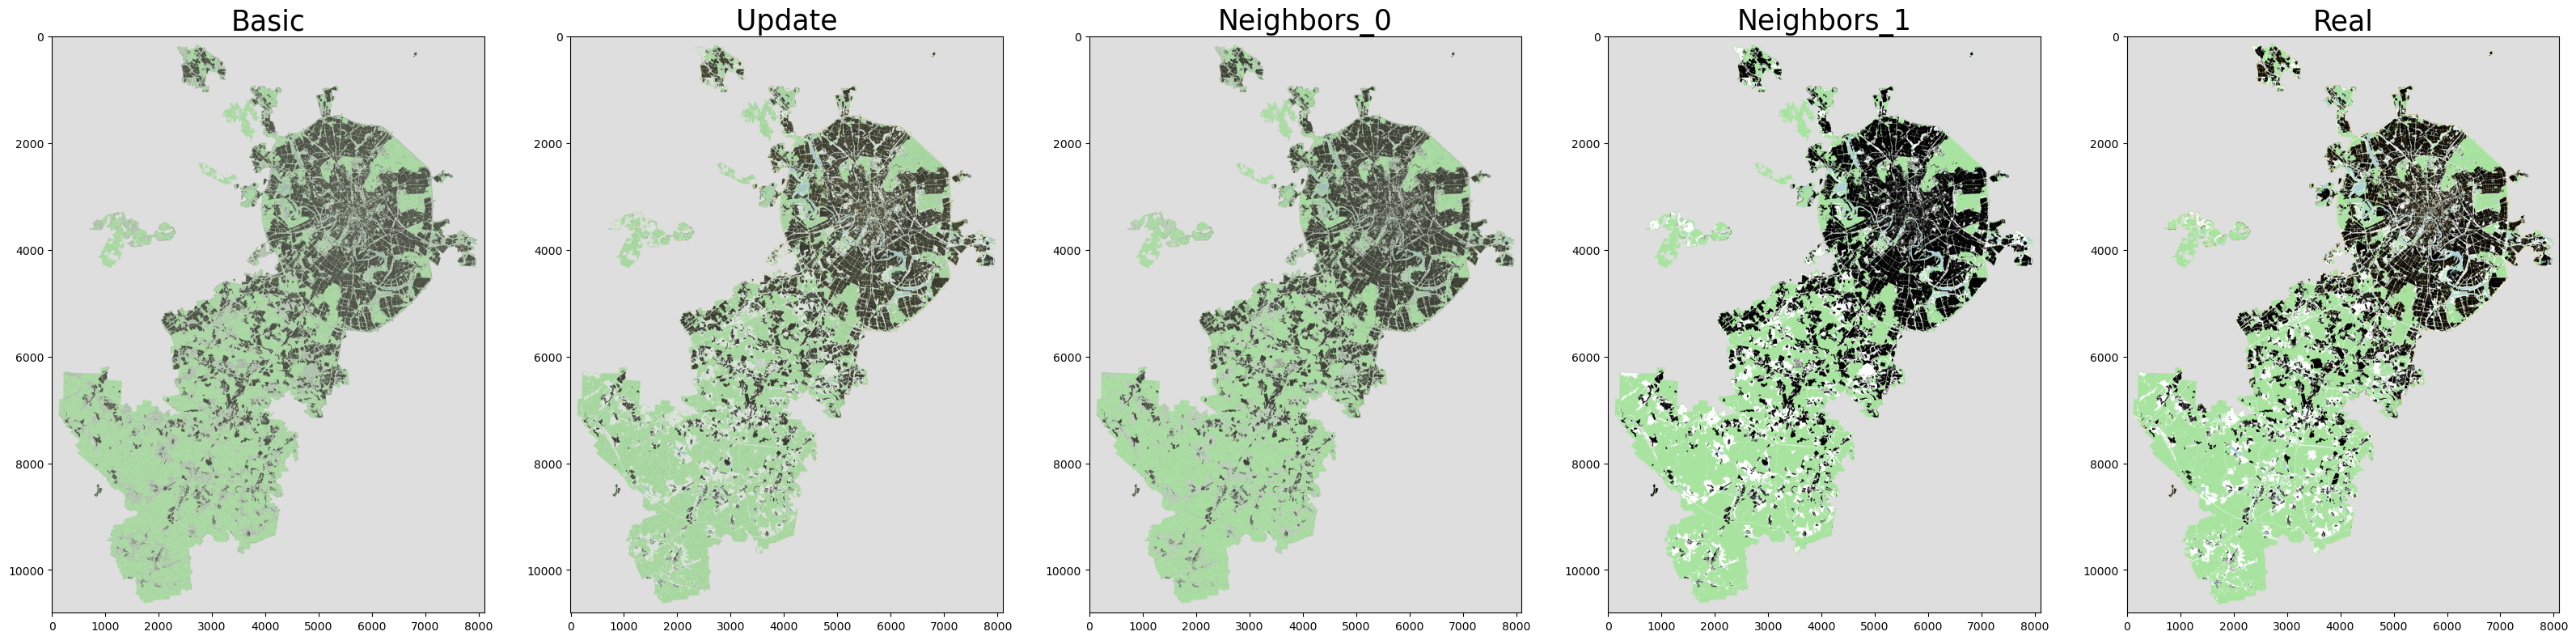

In [54]:
basic_pred_RGB = Image.fromarray(basic_pred.astype('uint8')).convert("RGB")
update_pred_RGB = Image.fromarray(update_pred.astype('uint8')).convert("RGB")
neighbors_pred_0_RGB = Image.fromarray(neighbors_pred_0.astype('uint8')).convert("RGB")
neighbors_pred_1_RGB = Image.fromarray(neighbors_pred_1.astype('uint8')).convert("RGB")

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(40,15))

axes[0].imshow(basic_pred_RGB)
axes[0].set_title('Basic', fontsize=25)
axes[1].imshow(update_pred_RGB)
axes[1].set_title('Update', fontsize=25)
axes[2].imshow(neighbors_pred_0_RGB)
axes[2].set_title('Neighbors_0', fontsize=25)
axes[3].imshow(neighbors_pred_1_RGB)
axes[3].set_title('Neighbors_1', fontsize=25)
axes[4].imshow(image_2024)
axes[4].set_title('Real', fontsize=25);

In [55]:
fig.savefig('Предсказания_big.png',bbox_inches='tight')

## Тестирование с помощью метрик

<p style="text-indent: 4em;">Рассмотрим алгоритмы для предсказани1 и посчитаем для них метрики. Алгоритм с лучшими метриками будем считать оптимальным. Будем сравнивать предсказанный 2024 год и фактический.

### Accuracy

<p style="text-indent: 4em;">Обеспечивает четкую и легко интерпретируемую метрику точности модели (0 = плохо, 1 = идеально). Практически это процент правильно классифицированных точек данных (пикселей, в данном случае) по сравнению с общим количеством точек данных :
     \begin{equation}
        \label{Accuracy}
        Accuracy = \frac{\text{Number of correctly classified data points}}{\text{total number of data points}} \cdot 100 \%
     \end{equation}

In [56]:
def CalculateAccuracy(pred_map, real_map):
    '''
    Input:
    pred_map, real_map
    Output:
    accuracy for pred_map based on real_map
    '''
    right_pred = 0
    for i in range(real_map.shape[0]):
        for j in range(real_map.shape[1]):
            if GetClass(real_map[i][j]) == GetClass(pred_map[i][j]):
                right_pred += 1
    
    return right_pred / (real_map.shape[0] * real_map.shape[1])

### Confusion matrix

Матрица ошибок - это матрица чисел, которая говорит нам, где модель путается. Это классовое распределение прогнозной производительности классификационной модели, то есть матрица ошибок является организованным способом отображения прогнозов в исходные классы, к которым относятся данные.

Такие матрицы не только позволяют  рассчитать точность классификатора, будь то глобальная или классовая точность, но также помогают вычислить другие важные метрики.

Матрица помогает для каждую клетку отнести к некоторой величене по условию:
* TP (true positives) - классификатор верно отнёс объект к рассматриваемому классу;
* TN (true negative) - классификатор верно утверждает, что объект не принадлежит к рассматриваемому классу;
* FP (false positives) - классификатор неверно отнёс объект к рассматриваемому классу;
* FN (false negative) - классификатор неверно утверждает, что объект не принадлежит к рассматриваемому классу.

Формально, матрица ошибок (CM) — это квадратная матрица размера $k \times k$, где $CM_{i, j}$ — число объектов класса $i$, которые были квалифицированны как класс $j$, а $k$ — число классов. Значения ячеек CM могут быть вычислены по формуле:
    \begin{equation}
    \label{conf_mat}
        CM(y, \hat{y})_{i,j} = \sum_{k = 1}^n [(y_k = i) \wedge (\hat{y}_k = j)]
    \end{equation}
    В этом случае TP, TN, FP и FN считаются относительно некоторого класса $i$ следующим образом:
    \begin{equation}
        \label{comp_cm}
           TP_i = CM_{i,i};~~FP_i = \sum_{k \neq i} CM_{i,k};~~FN_i= \sum_{k \neq i} CM_{k,i};~~
           TN_i = ALL - TP_i - FP_i - FN_i.
        \end{equation}
    Основываясь на этих данных мы можем найти  несколько оценок:
* Precision (точность) — показывает долю верно классифицированных объектов среди всех объектов, которые к этому классу отнес классификатор.
        \begin{equation}
        \label{Precision}
           \text{Precision}\_i = \frac{TP_i}{TP_i + FP_i}
        \end{equation}
* Recall (полнота) — показывает отношение верно классифицированных объектов класса к общему числу элементов этого класса.
        \begin{equation}
        \label{Recall}
           \text{Recall}\_i = \frac{TP_i}{TP_i + FN_i}
        \end{equation}
* Specificity — показывает отношение верных срабатываний классификатора к общему числу объектов за пределами класса.
        \begin{equation}
        \label{Specificity}
           \text{Specificity}\_i = \frac{TN_i}{FP_i + TN_i}
        \end{equation}

Каждая оценка должна стремиться к 1

In [57]:
def CalculateCM(data_pred, data_real):
    data_pred_classes = np.zeros(data_real.shape)
    data_real_classes = np.zeros(data_real.shape)
    for i in range(data_real.shape[0]):
        for j in range(data_real.shape[1]):
            data_pred_classes[i][j] = GetClass(data_pred[i][j])
            data_real_classes[i][j] = GetClass(data_real[i][j])
            
    
    vector_pred = data_pred_classes.flatten()
    vector_real = data_real_classes.flatten()
    
    conf_matrix = multilabel_confusion_matrix(vector_real, vector_pred, labels=[0, 1, 2, 3, 4, 5])
    
    
    row0 = ['Class', 'TP', 'FP', 'FN', 'TN', 'Recall', 'Precision', 'Specificity']
    table = [row0]
    
    for i in range(6):
        row = [i]
        row.append(conf_matrix[i][0][0])
        row.append(conf_matrix[i][0][1])
        row.append(conf_matrix[i][1][0])
        row.append(conf_matrix[i][1][1])
        recall = conf_matrix[i][0][0] / (conf_matrix[i][0][0] + conf_matrix[i][1][0])
        precision = conf_matrix[i][0][0] / (conf_matrix[i][0][0] + conf_matrix[i][0][1])
        specificity = conf_matrix[i][1][1] / (conf_matrix[i][0][1] + conf_matrix[i][1][1])
        row.append(recall)
        row.append(precision)
        row.append(specificity)
        table.append(row)
    
    print(tabulate(table, headers='firstrow', tablefmt='grid'))

Подсчет метрик:

In [58]:
print('BASIC')
print('Accuracy:', CalculateAccuracy(basic_pred, data_2024))
CalculateCM(basic_pred, data_2024)

BASIC
Accuracy: 0.8229130557879807
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|   Class |          TP |          FP |          FN |               TN |   Recall |   Precision |   Specificity |
+=========+=============+=============+=============+==================+==========+=============+===============+
|       0 | 7.7511e+07  | 9.12783e+06 | 3.8689e+06  |      1.71989e+08 | 0.952459 |    0.894645 |     0.949603  |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       1 | 2.58518e+08 | 1.64668e+06 | 1.95331e+06 | 378588           | 0.992501 |    0.993671 |     0.186932  |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       2 | 2.28833e+08 | 9.97594e+06 | 1.18148e+07 |      1.18728e+07 | 0.950904 |    0.958226 |     0.543409  |
+---------+-------------+-------------+-------------+

<p style="text-indent: 4em;">По данным из таблицы можно наблюдать, что данный метод плохо распознает дороги, водную территорию и растительность. Если рассматривать внешне карты, то наблюдается пониженная насыщенность по причине того, что классы Empty и Land смешались.

In [59]:
print('UPDATE')
print('Accuracy:', CalculateAccuracy(update_pred, data_2024))
CalculateCM(update_pred, data_2024)

UPDATE
Accuracy: 0.8387474489536731
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|   Class |          TP |          FP |          FN |               TN |   Recall |   Precision |   Specificity |
+=========+=============+=============+=============+==================+==========+=============+===============+
|       0 | 8.25508e+07 | 4.088e+06   | 4.13227e+06 |      1.71726e+08 | 0.952329 |    0.952816 |      0.976748 |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       1 | 2.58292e+08 | 1.87252e+06 | 1.54287e+06 | 789027           | 0.994062 |    0.992803 |      0.296454 |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       2 | 2.29634e+08 | 9.17489e+06 | 1.06382e+07 |      1.30494e+07 | 0.955724 |    0.961581 |      0.587169 |
+---------+-------------+-------------+-------------

<p style="text-indent: 4em;">Сравнивая модель с предыдущей, можно увидеть как повышение аccuracy, так и общее повышение остальных метрик. Однако проблемы с предсказанием дорог, воды и растительности остаются. Внешне, для карты наблюдается улучшение, изображение становиться более четким.

In [60]:
print('NEIGHBORS_0')
print('Accuracy:', CalculateAccuracy(neighbors_pred_0, data_2024))
CalculateCM(neighbors_pred_0, data_2024)

NEIGHBORS_0
Accuracy: 0.8400119219783114
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|   Class |          TP |          FP |          FN |               TN |   Recall |   Precision |   Specificity |
+=========+=============+=============+=============+==================+==========+=============+===============+
|       0 | 8.25497e+07 | 4.08911e+06 | 4.13217e+06 |      1.71726e+08 | 0.95233  |    0.952803 |     0.976742  |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       1 | 2.58479e+08 | 1.68587e+06 | 1.82478e+06 | 507117           | 0.99299  |    0.99352  |     0.231244  |
+---------+-------------+-------------+-------------+------------------+----------+-------------+---------------+
|       2 | 2.28789e+08 | 1.00197e+07 | 1.03282e+07 |      1.33594e+07 | 0.956807 |    0.958043 |     0.571425  |
+---------+-------------+-------------+--------

<p style="text-indent: 4em;">Neighbors (mode = 0) обгоняет по точности прошлые методы, но в остальных метриках остается на прежнем уровне. На изображении можно увидеть, что класс Vegetation полностю перешел в класс Empty (ошибки в предсказании для класса Vegetation).

In [61]:
print('NEIGHBORS_1')
print('Accuracy:', CalculateAccuracy(neighbors_pred_1, data_2024))
CalculateCM(neighbors_pred_1, data_2024)

NEIGHBORS_1
Accuracy: 0.8905347622594711
+---------+-------------+------------------+-------------+------------------+----------+-------------+---------------+
|   Class |          TP |               FP |          FN |               TN |   Recall |   Precision |   Specificity |
+=========+=============+==================+=============+==================+==========+=============+===============+
|       0 | 8.25508e+07 |      4.08801e+06 | 4.13225e+06 |      1.71726e+08 | 0.952329 |    0.952815 |      0.976748 |
+---------+-------------+------------------+-------------+------------------+----------+-------------+---------------+
|       1 | 2.59679e+08 | 485946           | 1.45041e+06 | 881490           | 0.994446 |    0.998132 |      0.64463  |
+---------+-------------+------------------+-------------+------------------+----------+-------------+---------------+
|       2 | 2.30383e+08 |      8.4257e+06  | 4.91727e+06 |      1.87703e+07 | 0.979102 |    0.964718 |      0.690187 |
+------

<p style="text-indent: 4em;">Данный метод показывает очень высокую accuracy для алгоритма. Также наблюдается сильное улучшение при предсказывании не только водных территорий, дорог и растительности, но и в общем для всех классов. Для разрешения в 1000dpi Neighbors (mode = 1) допускает ошибки всего с вероятностью $0.11$.
Внешне, предсказание данного метода очень похожи на фактическую карту.

### Итог
<p style="text-indent: 4em;">Подробно рассмотрев методы, был сделан вывод, что лучше всего проявляет себя Neighbors с первым режимом предсказывания.  Таким образом, было принято решение использовать Neighbors (mode = 1) для моделирования развития города. Однако, стоит учитывать, что возможны ошибки при работе с некоторыми классами.

## Моделирование развития города
<p style="text-indent: 4em;"> Вот мы и подошли к главной задачи проекта: смоделировать развитие города Москвы на 2029-2030 года. Производить моделирование будем с помощью модели NEIGHBORS_1.

Произведем вычисления:

In [62]:
predict_2030 = NeighborsCA_Predict(data, map_2024, 1)

28879602 1


Проведем сравнение между 2024 годом и предсказанным 2030:

In [63]:
CompareMaps(data_2024, predict_2030, first_name='2024', second_name='predicted 2030')

+----------------+-------------+-------------+--------------+------------+-------------+---------------+
| Image          |       Empty |       Water |        Urban |       Road |        Land |    Vegetation |
+================+=============+=============+==============+============+=============+===============+
| 2024           | 5.86193e+07 | 777299      |  7.89587e+06 | 634117     | 1.39723e+07 |   5.60003e+06 |
+----------------+-------------+-------------+--------------+------------+-------------+---------------+
| Change in %    | 4.77658e-05 |    -37.2995 | 19.1196      |    -98.236 | 6.42181     | -26.6802      |
+----------------+-------------+-------------+--------------+------------+-------------+---------------+
| predicted 2030 | 5.86193e+07 | 487370      |  9.40552e+06 |  11186     | 1.48696e+07 |   4.10593e+06 |
+----------------+-------------+-------------+--------------+------------+-------------+---------------+


Таким образом, вот таким получился результат нашего исследования. Изобразим для сравнения все карты:

In [64]:
predicted_2030_RGB = Image.fromarray(predict_2030.astype('uint8')).convert("RGB")

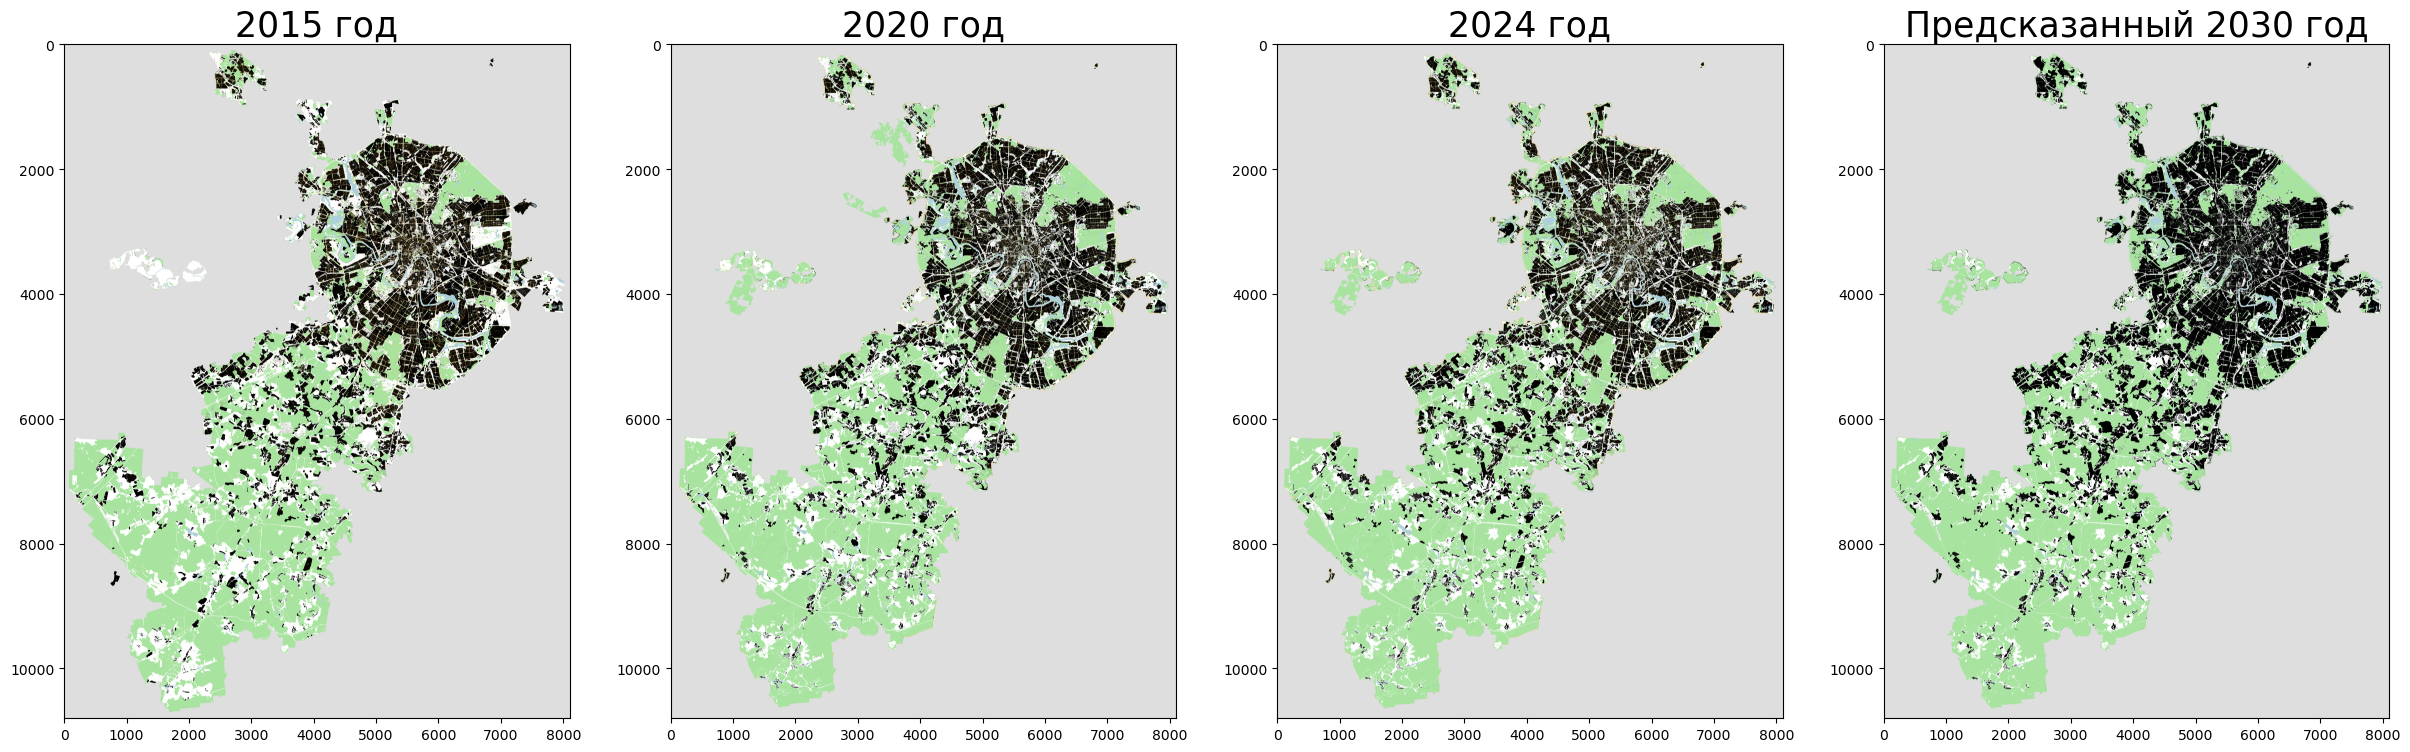

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30,10))

axes[0].imshow(image_2015)
axes[0].set_title('2015 год', fontsize=25)
axes[1].imshow(image_2020)
axes[1].set_title('2020 год', fontsize=25)
axes[2].imshow(image_2024)
axes[2].set_title('2024 год', fontsize=25)
axes[3].imshow(predicted_2030_RGB)
axes[3].set_title('Предсказанный 2030 год', fontsize=25)
None

In [66]:
fig.savefig('Итог_big.png',bbox_inches='tight')

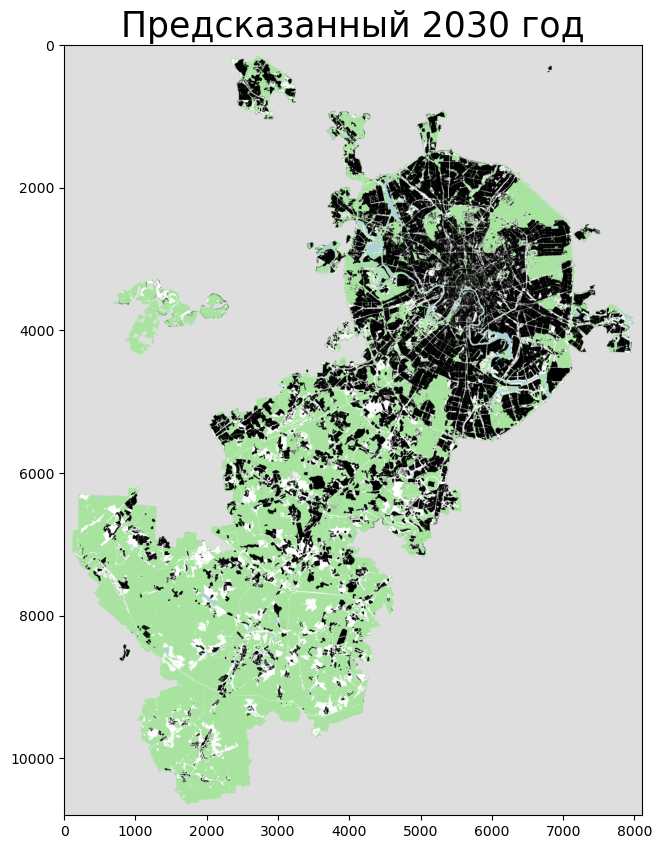

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

axes.imshow(predicted_2030_RGB)
axes.set_title('Предсказанный 2030 год', fontsize=25)
None

In [69]:
fig.savefig('Предсказанный_2030_big.png',bbox_inches='tight')

## Анализ
<p style="text-indent: 4em;">Сравнение общей площади территорий, занимаемых классами в прогнозируемой карте, с 2024 годом показывает, что увеличится площадь градостроений в городе за счет снижения территорий с растительностью. Но на рисунке можно увидеть как город развивается во всех направлениях, что может предвещать начало крупных застроек в ближайшие года. Однако, как и в тестировании модели, наблюдаются ошибки при работе с дорогами и водными территориями.